
<div align="center"> 

# ForwardOnly_MLP

<p align="center"> 
  <img src="https://mad-institute.com/images/universitys/iranuniversity2.png" alt="IUST Logo" width="180" height="180"> 
</p> 

**University:** IRAN University of Science and Technology  
**Course:** Deep Learning  
**Term:** First semester of academic year 1404–1405 
</div>



## Notebook: Forward-Only MLP with Fixed Weights — *Evaluation-Only*

We implement a small **two-layer MLP** and run it **forward-only** (no learning). You will:
- Choose **activations** (ReLU / Tanh / Sigmoid / GELU) and **fixed weights/biases**.
- Generate synthetic **regression** *or* **classification** data.
- Compute **MSE/MAE** (regression) or **Cross-Entropy** (classification).
- Visualize **pre-activations**, **activations**, and **loss contributions** to study **saturation** vs **linear** regimes.

> **Forbidden in this unit:** model selection, regularization, dropout, label smoothing, adversarial training, backpropagation, and gradient-based optimizers. Everything here is **forward-only** and **evaluation-only**.



### Learning Objectives
1. Implement a configurable **forward** pass for a 2-layer MLP with **fixed** parameters.
2. Compare activations by analyzing **output distributions** and **loss metrics**.
3. Visualize and interpret **saturation** and its effect on predictions.
4. Design small experiments (weight scale, input scale, activation choice) to produce insightful **plots** and **tables**.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
print("NumPy:", np.__version__, "| pandas:", pd.__version__)


NumPy: 2.3.1 | pandas: 2.3.1



## Part A — Mode & Data (Synthetic)

Pick **one** task mode:
- **Regression**: predict a continuous target; evaluate with **MSE/MAE**.
- **Classification**: predict a class (binary or multiclass); evaluate with **Cross-Entropy**.

**TODO ideas:**
- Vary input noise, class overlap, or nonlinearity.
- Keep weights **fixed** across experiments; change only data conditions (evaluation-only).


In [ ]:
# ------------------------------ TODO: Select task mode --------------------------------
MODE = "classification"  # TODO: choose "regression" or "classification" based on the experiment you want

# ------------------------------ Data parameters ---------------------------------------
n = 400                # number of samples (keep as-is; not educational to modify here)
d = 4                  # input dimension
C = 3                  # number of classes (used if MODE == "classification")

# Regression ground-truth
def f_reg(x):
    # TODO: Implement a smooth nonlinear target mapping for regression.
    # Suggestion: 
    # 1) Pick a fixed weight vector w of length d (e.g., manually set a few numbers).
    # 2) Compute a scalar projection z = x @ w.
    # 3) Return a combination like: a * tanh(z) + b * z + c (use small constants).
    pass

# Classification score generator (for synthetic labels)
def f_cls_scores(x):
    # TODO: Produce class scores S for C classes from inputs x with fixed, known parameters.
    # Suggested steps:
    # 1) Define a fixed weight matrix W_true of shape (C, d) with simple patterns (e.g., linspace rows).
    # 2) Define a fixed bias vector b_true of length C (e.g., linspace).
    # 3) Compute and return S = x @ W_true.T + b_true.
    pass

# ------------------------------ Generate inputs ---------------------------------------
X = np.random.randn(n, d)  # standard normal inputs (keep; not pedagogically central)

if MODE == "regression":
    # TODO: Generate regression targets y using f_reg(X) and add small Gaussian noise.
    # Example guidance: y = f_reg(X) + noise_level * np.random.randn(n)
    # Then construct a DataFrame with columns x0..x{d-1}, y
    # (You can keep the DataFrame creation as-is below once y exists.)
    # y = ...
    df = pd.DataFrame(np.c_[X, y], columns=[*(f"x{i}" for i in range(d)), "y"])

elif MODE == "classification":
    # TODO: Get raw class scores S = f_cls_scores(X) and optionally add moderate Gaussian noise to S.
    # TODO: Convert scores to hard labels with argmax over classes.
    # Then construct a DataFrame with columns x0..x{d-1}, y
    # (You can keep the DataFrame creation as-is below once y exists.)
    # S = ...
    # y = ...
    df = pd.DataFrame(np.c_[X, y], columns=[*(f"x{i}" for i in range(d)), "y"])

else:
    raise ValueError("MODE must be 'regression' or 'classification'")

df.head()  # keep: quick sanity-check of the generated dataset


,x0,x1,x2,x3,y
0,0.496714,-0.138264,0.647689,1.523030,0.0
1,-0.234153,-0.234137,1.579213,0.767435,0.0
2,-0.469474,0.542560,-0.463418,-0.465730,1.0
3,0.241962,-1.913280,-1.724918,-0.562288,1.0
4,-1.012831,0.314247,-0.908024,-1.412304,2.0


In [ ]:
# ======================= Unit Tests (print-only PASS/FAIL) =======================

import numpy as np
import pandas as pd

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# 1) MODE should be valid
tests.append(lambda: 'MODE' in globals() and MODE in ("regression", "classification"))

# 2) X should have correct shape
tests.append(lambda: 'X' in globals() and isinstance(X, np.ndarray) and X.shape == (n, d))

# 3) df should have correct type and shape
tests.append(lambda: 'df' in globals() and isinstance(df, pd.DataFrame) and df.shape[0] == n and df.shape[1] == d + 1)

# 4) df columns should be x0..x{d-1}, y
tests.append(lambda: list(df.columns) == [*(f"x{i}" for i in range(d)), "y"])

# 5) y should exist and have length n
tests.append(lambda: 'y' in globals() and (isinstance(y, (np.ndarray, pd.Series, list))) and len(y) == n)

# 6) y should not be constant (positive variance)
tests.append(lambda: np.var(np.asarray(y, dtype=float)) > 0)

# 7) If regression mode, y should be float
tests.append(lambda: (MODE == "regression" and np.issubdtype(np.asarray(y).dtype, np.floating)) or (MODE != "regression"))

# 8) If classification mode, labels should be in [0, C-1]
tests.append(lambda: (MODE == "classification" and 
                      np.all(np.asarray(y, dtype=int) >= 0) and 
                      np.all(np.asarray(y, dtype=int) < C)) or (MODE != "classification"))

# 9) If classification mode, at least one and at most C unique classes
tests.append(lambda: (MODE == "classification" and 
                      1 <= np.unique(np.asarray(y, dtype=int)).size <= C) or (MODE != "classification"))

# 10) df['y'] should match y
tests.append(lambda: np.all(np.asarray(df['y']) == np.asarray(y)))

# 11) Generator functions should exist
tests.append(lambda: 'f_reg' in globals() and callable(f_reg) and 'f_cls_scores' in globals() and callable(f_cls_scores))

# 12) If classification, S should exist and have shape (n, C)
tests.append(lambda: (MODE == "classification" and 'S' in globals() and isinstance(S, np.ndarray) and S.shape == (n, C)) or (MODE != "classification"))

# Run tests (print only PASS/FAIL)
for t in tests:
    run_test(t)

for r in results:
    print(r)
# ================================================================================



## Part B — Split (Train/Dev/Test)

We split randomly into train/dev/test for **evaluation-only** reporting (no fitting).  
Weights are **fixed** and do not change across splits.


In [ ]:

# TODO: Decide split sizes:
#       - n_train = int(0.6 * n)
#       - n_dev   = int(0.2 * n)
#       - n_test  = n - n_train - n_dev  (implicitly via slicing)

# TODO: Generate a random permutation of indices 0..n-1:
#       - perm = np.random.permutation(n)

# TODO: Create index splits from the permutation:
#       - idx_train = perm[:n_train]
#       - idx_dev   = perm[n_train : n_train + n_dev]
#       - idx_test  = perm[n_train + n_dev :]

# TODO: Split features by indexing:
#       - X_train = X[idx_train]
#       - X_dev   = X[idx_dev]
#       - X_test  = X[idx_test]

# TODO: Split targets by indexing:
#       - y_train = y[idx_train]
#       - y_dev   = y[idx_dev]
#       - y_test  = y[idx_test]


print("Splits:", len(y_train), len(y_dev), len(y_test))


Splits: 240 80 80


In [ ]:
# ======================= Unit Tests for Splits (print-only PASS/FAIL) =======================

import numpy as np
import pandas as pd

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# 1) Required globals exist
tests.append(lambda: all(k in globals() for k in [
    'n','d','X','y','perm','n_train','n_dev',
    'idx_train','idx_dev','idx_test',
    'X_train','X_dev','X_test','y_train','y_dev','y_test'
]))

# 2) perm is a permutation of 0..n-1
tests.append(lambda: isinstance(perm, np.ndarray)
             and perm.shape == (n,)
             and np.array_equal(np.sort(perm), np.arange(n)))

# 3) Split sizes align with indices
tests.append(lambda: len(idx_train) == n_train and len(idx_dev) == n_dev
             and len(idx_test) == (n - n_train - n_dev))

# 4) Index ranges are valid (within [0, n))
tests.append(lambda: all(0 <= int(i) < n for i in np.concatenate([idx_train, idx_dev, idx_test])))

# 5) Splits are disjoint (no overlap)
tests.append(lambda: len(set(idx_train)) + len(set(idx_dev)) + len(set(idx_test))
             == len(set(np.concatenate([idx_train, idx_dev, idx_test]))))

# 6) Splits cover exactly all indices in perm (order not required)
tests.append(lambda: set(np.concatenate([idx_train, idx_dev, idx_test])) == set(perm))

# 7) X_* have correct shapes
tests.append(lambda: X_train.shape == (len(idx_train), d)
             and X_dev.shape == (len(idx_dev), d)
             and X_test.shape == (len(idx_test), d))

# 8) y_* have correct lengths
tests.append(lambda: len(y_train) == len(idx_train)
             and len(y_dev) == len(idx_dev)
             and len(y_test) == len(idx_test))

# 9) X_* correspond to X indexed by the same idx_*
tests.append(lambda: np.array_equal(X_train, X[idx_train])
             and np.array_equal(X_dev, X[idx_dev])
             and np.array_equal(X_test, X[idx_test]))

# 10) y_* correspond to y indexed by the same idx_*
tests.append(lambda: np.array_equal(np.asarray(y_train), np.asarray(y)[idx_train])
             and np.array_equal(np.asarray(y_dev),   np.asarray(y)[idx_dev])
             and np.array_equal(np.asarray(y_test),  np.asarray(y)[idx_test]))

# 11) Label/value distributions are non-degenerate in each split (some variance)
tests.append(lambda: np.var(np.asarray(y_train, dtype=float)) > 0
             and np.var(np.asarray(y_dev, dtype=float)) > 0
             and np.var(np.asarray(y_test, dtype=float)) > 0)

# 12) Counts add up and match the print
tests.append(lambda: (len(y_train) + len(y_dev) + len(y_test) == n)
             and len(y_train) == n_train and len(y_dev) == n_dev
             and len(y_test) == (n - n_train - n_dev))

# 13) Indices are contiguous slices of perm (expected by construction)
tests.append(lambda: np.array_equal(idx_train, perm[:n_train])
             and np.array_equal(idx_dev,   perm[n_train:n_train+n_dev])
             and np.array_equal(idx_test,  perm[n_train+n_dev:]))

# Run tests
for t in tests:
    run_test(t)

# Print only PASS/FAIL lines
for r in results:
    print(r)
# ===========================================================================================



## Part C — MLP (Forward Only)

Architecture: **d → m → out** with a chosen activation on the hidden layer. Output layer:
- Regression: linear output (no activation).
- Classification: raw logits → **softmax** only for **CE computation**.

**TODO ideas:**
- Change `m` (hidden size) and **weight scales** to expose saturation.
- Try multiple activations and compare losses.
- Optionally **load weights** from `.npy` (see hooks below).


In [ ]:
# ------------------------------ TODO: MLP configuration --------------------------------
m = 32                         # low-value: keep as-is
w_scale_1 = 0.8                # low-value: keep as-is
w_scale_2 = 0.8                # low-value: keep as-is
b_scale_1 = 0.0                # low-value: keep as-is
b_scale_2 = 0.0                # low-value: keep as-is
ACT = "relu"                   # TODO: choose from {"relu","tanh","sigmoid","gelu"}

# ------------------------------ Activations --------------------------------------------
# TODO: Implement ReLU:
#       - Input: z (array-like)
#       - Output: elementwise max(z, 0)
# def relu(z): ...

# TODO: Implement tanh:
#       - Use np.tanh(z)
# def tanh(z): ...

# TODO: Implement sigmoid:
#       - Use 1 / (1 + exp(-z)) in a numerically stable way if needed
# def sigmoid(z): ...

# TODO: Implement GELU (approximate, Hendrycks & Gimpel):
#       - 0.5 * z * (1 + tanh( sqrt(2/pi) * (z + 0.044715 * z^3 ) ))
# def gelu(z): ...

# TODO: Activation dispatch:
#       - If name == "relu": call relu
#       - If name == "tanh": call tanh
#       - If name == "sigmoid": call sigmoid
#       - If name == "gelu": call gelu
#       - Else: raise ValueError("Unknown activation")
# def act_forward(z, name): ...

# TODO: Stable softmax over rows:
#       - Subtract row-wise max for stability
#       - exp and normalize by row-wise sum
# def softmax(Z): ...

# ------------------------------ Fixed parameters (random, then *frozen*) ----------------
rng = np.random.default_rng(123)   # low-value: keep as-is

# TODO: Initialize first layer:
#       - W1 shape: (d, m) ~ N(0,1) scaled by w_scale_1 using rng.standard_normal
#       - b1 shape: (m,)   ~ N(0,1) scaled by b_scale_1
# W1 = ...
# b1 = ...

# TODO: Initialize second layer depending on MODE:
#       - If MODE == "regression":
#           * W2 shape: (m, 1) ~ N(0,1) scaled by w_scale_2
#           * b2 shape: (1,)   ~ N(0,1) scaled by b_scale_2
#           * out_dim = 1
#       - Else (classification):
#           * W2 shape: (m, C) ~ N(0,1) scaled by w_scale_2
#           * b2 shape: (C,)   ~ N(0,1) scaled by b_scale_2
#           * out_dim = C
# W2 = ...
# b2 = ...
# out_dim = ...

# ------------------------------ Forward function ----------------------------------------
# TODO: Implement mlp_forward(X_in, act="relu", return_intermediates=False):
#       1) Compute pre-activation of layer 1:
#          - z1 = X_in @ W1 + b1
#       2) Apply nonlinearity:
#          - h1 = act_forward(z1, act)
#       3) Compute layer-2 output (logits or regression output):
#          - z2 = h1 @ W2 + b2
#       4) Branch by MODE:
#          - If MODE == "classification":
#              * y_pred_probs = softmax(z2)     # for reporting / cross-entropy
#              * out = y_pred_probs
#          - Else (regression):
#              * out = z2 reshaped to (N,)      # flatten single output
#       5) If return_intermediates:
#              * return out, (z1, h1, z2)
#          Else:
#              * return out
# def mlp_forward(X_in, act="relu", return_intermediates=False): ...


In [ ]:
# ======================= Unit Tests for MLP (print-only PASS/FAIL) =======================

import numpy as np
import pandas as pd

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# Convenience
Ncheck = min(7, len(X))  # small batch to test forward
X_small = X[:Ncheck]
X_zero = np.zeros_like(X_small)

# 1) Required globals and callables exist
tests.append(lambda: all(k in globals() for k in [
    'm','w_scale_1','w_scale_2','b_scale_1','b_scale_2','ACT',
    'relu','tanh','sigmoid','gelu','act_forward','softmax',
    'rng','W1','b1','W2','b2','out_dim','mlp_forward','MODE','d'
]) and all(callable(globals()[k]) for k in ['relu','tanh','sigmoid','gelu','act_forward','softmax','mlp_forward']))

# 2) Weight/bias shapes are correct
tests.append(lambda: W1.shape == (d, m) and b1.shape == (m,) and
             ((MODE == "regression" and W2.shape == (m, 1) and b2.shape == (1,) and out_dim == 1) or
              (MODE == "classification" and 'C' in globals() and W2.shape == (m, C) and b2.shape == (C,) and out_dim == C)))

# 3) Activations run and preserve shape
tests.append(lambda: all(
    getattr(np, 'all')(np.isfinite(fn(X_small))) and fn(X_small).shape == X_small.shape
    for fn in [relu, tanh, sigmoid, gelu]
))

# 4) act_forward dispatch works for all known names
tests.append(lambda: all(
    act_forward(X_small, name).shape == X_small.shape
    for name in ["relu","tanh","sigmoid","gelu"]
))

# 5) softmax is row-stochastic on logits: rows sum to 1 and are nonnegative
def _softmax_ok():
    Z = np.random.randn(Ncheck, max(2, out_dim))
    P = softmax(Z)
    s = np.abs(P.sum(axis=1) - 1.0)
    return P.shape == Z.shape and np.all(P >= 0) and np.all(s < 1e-6)
tests.append(_softmax_ok)

# 6) Forward pass returns correct shape/type for current MODE
def _forward_shape_ok():
    out = mlp_forward(X_small, act=ACT, return_intermediates=False)
    if MODE == "classification":
        return isinstance(out, np.ndarray) and out.shape == (Ncheck, out_dim) and np.allclose(out.sum(axis=1), 1.0, atol=1e-5)
    else:
        return isinstance(out, np.ndarray) and out.shape == (Ncheck,) and np.issubdtype(out.dtype, np.floating)
tests.append(_forward_shape_ok)

# 7) Forward pass with intermediates returns (out, (z1,h1,z2)) with proper shapes
def _forward_intermediates_ok():
    out, (z1, h1, z2) = mlp_forward(X_small, act=ACT, return_intermediates=True)
    ok = (z1.shape == (Ncheck, m)) and (h1.shape == (Ncheck, m)) and (z2.shape == (Ncheck, out_dim))
    if MODE == "classification":
        ok = ok and out.shape == (Ncheck, out_dim)
    else:
        ok = ok and out.shape == (Ncheck,)
    return ok
tests.append(_forward_intermediates_ok)

# 8) Different activation names should work in mlp_forward
tests.append(lambda: all(
    (lambda o: (o.shape == (Ncheck, out_dim)) if MODE == "classification" else (o.shape == (Ncheck,)))(mlp_forward(X_small, act=name))
    for name in ["relu","tanh","sigmoid","gelu"]
))

# 9) Forward on zero input should be finite and have correct shape
def _zero_input_ok():
    out = mlp_forward(X_zero, act=ACT)
    finite = np.all(np.isfinite(out))
    if MODE == "classification":
        return finite and out.shape == (Ncheck, out_dim) and np.allclose(out.sum(axis=1), 1.0, atol=1e-5)
    else:
        return finite and out.shape == (Ncheck,)
tests.append(_zero_input_ok)

# 10) out_dim is consistent with MODE
tests.append(lambda: (MODE == "classification" and out_dim == C) or (MODE == "regression" and out_dim == 1) or False is False)

# 11) Softmax invariance to constant shift (numerical stability check)
def _softmax_shift_invariance():
    Z = np.random.randn(Ncheck, max(2, out_dim))
    shift = 10.0
    return np.allclose(softmax(Z), softmax(Z + shift), atol=1e-8)
tests.append(_softmax_shift_invariance)

# 12) ACT string is one of the allowed set
tests.append(lambda: ACT in {"relu","tanh","sigmoid","gelu"})

# 13) Calling act_forward with unknown name raises ValueError
def _dispatch_raises():
    try:
        act_forward(X_small, "does-not-exist")
        return False
    except ValueError:
        return True
tests.append(_dispatch_raises)

# 14) Forward pass does not mutate inputs
def _no_input_mutation():
    x_copy = X_small.copy()
    _ = mlp_forward(X_small, act=ACT)
    return np.array_equal(X_small, x_copy)
tests.append(_no_input_mutation)

# Run tests
for t in tests:
    run_test(t)

# Print only PASS/FAIL lines (one per test in defined order)
for r in results:
    print(r)
# =======================================================================================



## Part D — Loss Functions (Evaluation Only)

- **Regression:** `MSE`, `MAE` on predictions vs targets.  
- **Classification:** **Cross-Entropy** using softmax probabilities.


In [ ]:
# TODO: Mean Squared Error (MSE)
# def mse(y_true, y_pred):
#     # Low-value: convert inputs to float numpy arrays
#     # TODO: compute elementwise squared error: (y_pred - y_true) ** 2
#     # TODO: take the mean over all elements
#     # TODO: return the scalar as a Python float


# TODO: Mean Absolute Error (MAE)
# def mae(y_true, y_pred):
#     # Low-value: convert inputs to float numpy arrays
#     # TODO: compute elementwise absolute error: abs(y_pred - y_true)
#     # TODO: take the mean over all elements
#     # TODO: return the scalar as a Python float


# TODO: Multiclass Cross-Entropy (negative log-likelihood)
# def ce_multiclass(y_true_int, p_pred, eps=1e-12):
#     # Assumptions:
#     #   - y_true_int: integer class labels in [0, C-1], shape (N,)
#     #   - p_pred: predicted probabilities, shape (N, C), rows sum to ~1
#     #
#     # Low-value: ensure p_pred is a NumPy array of floats and y_true_int is integer array
#     # TODO: clip probabilities to [eps, 1 - eps] for numerical stability
#     # TODO: gather the predicted probability of the true class for each sample
#     #       (advanced indexing using (np.arange(N), y_true_int))
#     # TODO: compute -mean(log(p_true_class))
#     # TODO: return the scalar as a Python float


In [ ]:
# ======================= Unit Tests for Metrics (print-only PASS/FAIL) =======================

import numpy as np

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# --- Sanity data ---
y_true_1d = np.array([0.0, 1.0, 2.0, -1.0, 3.5])
y_pred_1d = np.array([0.0, 1.5, 1.0, -2.0, 3.0])

# 1) Functions exist and are callable
tests.append(lambda: all(name in globals() and callable(globals()[name])
                         for name in ["mse","mae","ce_multiclass"]))

# 2) MSE on simple known values
def _mse_known():
    # manual: ((0-0)^2 + (1.5-1)^2 + (1-2)^2 + (-2+1)^2 + (3-3.5)^2)/5
    manual = (0**2 + 0.5**2 + (-1)**2 + (-1)**2 + (-0.5)**2)/5
    return np.isclose(mse(y_true_1d, y_pred_1d), manual, rtol=0, atol=1e-12)
tests.append(_mse_known)

# 3) MAE on simple known values
def _mae_known():
    # manual: (|0-0| + |1.5-1| + |1-2| + |-2+1| + |3-3.5|)/5
    manual = (0 + 0.5 + 1 + 1 + 0.5)/5
    return np.isclose(mae(y_true_1d, y_pred_1d), manual, rtol=0, atol=1e-12)
tests.append(_mae_known)

# 4) MSE is zero when predictions equal truths
tests.append(lambda: np.isclose(mse([1,2,3],[1,2,3]), 0.0))

# 5) MAE is zero when predictions equal truths
tests.append(lambda: np.isclose(mae([1,2,3],[1,2,3]), 0.0))

# 6) MSE/MAE accept lists and different dtypes (broadcastability in numpy sense not required)
tests.append(lambda: isinstance(mse([0,1],[0.0,1.0]), float) and isinstance(mae([0,1],[0.0,1.0]), float))

# 7) MSE/MAE handle negative and non-integer values
tests.append(lambda: np.isfinite(mse([-1.2, 3.4], [0.8, 3.0])) and np.isfinite(mae([-1.2, 3.4], [0.8, 3.0])))

# --- Cross-entropy tests ---
# Prepare small classification example (N=4, C=3)
y_true_int = np.array([0, 2, 1, 2], dtype=int)
P = np.array([
    [0.7, 0.2, 0.1],  # correct: class 0
    [0.1, 0.2, 0.7],  # correct: class 2
    [0.2, 0.6, 0.2],  # correct: class 1
    [0.05,0.15,0.80], # correct: class 2
], dtype=float)

# 8) ce_multiclass returns finite scalar and type float
tests.append(lambda: isinstance(ce_multiclass(y_true_int, P), float) and np.isfinite(ce_multiclass(y_true_int, P)))

# 9) ce_multiclass matches manual computation for known example
def _ce_known():
    # manual negative log-likelihood
    p_true = np.array([0.7, 0.7, 0.6, 0.80])
    manual = -np.mean(np.log(p_true))
    return np.isclose(ce_multiclass(y_true_int, P), manual, atol=1e-12)
tests.append(_ce_known)

# 10) ce_multiclass clips near 0/1 safely (no -inf or nan)
def _ce_clip():
    y = np.array([0, 1], dtype=int)
    P_bad = np.array([[1.0, 0.0],   # exact 0 and 1
                      [0.0, 1.0]], dtype=float)
    val = ce_multiclass(y, P_bad, eps=1e-12)
    return np.isfinite(val) and val >= 0.0
tests.append(_ce_clip)

# 11) ce_multiclass decreases when true-class probability increases
def _ce_monotone():
    y = np.array([1], dtype=int)
    p_low  = np.array([[0.8, 0.2]])
    p_high = np.array([[0.2, 0.8]])
    return ce_multiclass(y, p_high) < ce_multiclass(y, p_low)
tests.append(_ce_monotone)

# 12) ce_multiclass supports different eps values without crashing
tests.append(lambda: np.isfinite(ce_multiclass(y_true_int, P, eps=1e-6)))

# 13) Inputs not mutated by metrics (no in-place ops)
def _no_mutation():
    yt = y_true_1d.copy()
    yp = y_pred_1d.copy()
    _ = mse(yt, yp); _ = mae(yt, yp)
    return np.array_equal(yt, y_true_1d) and np.array_equal(yp, y_pred_1d)
tests.append(_no_mutation)

# 14) Works with column-vector vs 1D vector shapes (common pitfall)
def _shape_flex():
    yt = np.array([[0.0],[1.0],[2.0]])
    yp = np.array([0.0, 1.0, 2.0])
    # Broadcasting to float arrays inside functions should make this finite
    return np.isfinite(mse(yt, yp)) and np.isfinite(mae(yt, yp))
tests.append(_shape_flex)

# Run tests
for t in tests:
    run_test(t)

# Print only PASS/FAIL
for r in results:
    print(r)
# ===========================================================================================



## Part E — Evaluation & Basic Tables

We forward the MLP on each split and compute the appropriate metrics.


In [ ]:
# ============================== TODOs for Forward & Metrics ==============================

# TODO: If MODE == "regression":
#   1) Run forward passes with intermediates:
#        - yhat_train, inter_train = mlp_forward(X_train, ACT, return_intermediates=True)
#        - yhat_dev,   inter_dev   = mlp_forward(X_dev,   ACT, return_intermediates=True)
#        - yhat_test,  inter_test  = mlp_forward(X_test,  ACT, return_intermediates=True)
#      (Low-value detail: 'inter_*' holds (z1, h1, z2); keep API consistent with earlier.)
#
#   2) Compute metrics per split using previously defined mse/mae:
#        - train: MSE = mse(y_train, yhat_train), MAE = mae(y_train, yhat_train)
#        - dev:   MSE = mse(y_dev,   yhat_dev),   MAE = mae(y_dev,   yhat_dev)
#        - test:  MSE = mse(y_test,  yhat_test),  MAE = mae(y_test,  yhat_test)
#
#   3) Build a small table (list of dicts) and create a DataFrame:
#        rows = [
#          {"split": "train", "MSE": <...>, "MAE": <...>},
#          {"split": "dev",   "MSE": <...>, "MAE": <...>},
#          {"split": "test",  "MSE": <...>, "MAE": <...>}
#        ]
#        df_metrics = pd.DataFrame(rows)

# TODO: Else (classification):
#   1) Run forward passes with intermediates to get class probabilities:
#        - p_train, inter_train = mlp_forward(X_train, ACT, return_intermediates=True)
#        - p_dev,   inter_dev   = mlp_forward(X_dev,   ACT, return_intermediates=True)
#        - p_test,  inter_test  = mlp_forward(X_test,  ACT, return_intermediates=True)
#
#   2) Define trivial utilities (low educational value; keep concise):
#        - pred_from_probs(p): argmax over axis=1
#        - acc(y_true, y_pred): mean equality
#
#   3) Compute metrics per split using ce_multiclass + accuracy:
#        - train: CE = ce_multiclass(y_train, p_train), ACC = acc(y_train, pred_from_probs(p_train))
#        - dev:   CE = ce_multiclass(y_dev,   p_dev),   ACC = acc(y_dev,   pred_from_probs(p_dev))
#        - test:  CE = ce_multiclass(y_test,  p_test),  ACC = acc(y_test,  pred_from_probs(p_test))
#
#   4) Build a table and create a DataFrame:
#        rows = [
#          {"split": "train", "CE": <...>, "ACC": <...>},
#          {"split": "dev",   "CE": <...>, "ACC": <...>},
#          {"split": "test",  "CE": <...>, "ACC": <...>}
#        ]
#        df_metrics = pd.DataFrame(rows)

# TODO: Finally, display df_metrics (e.g., last-line expression to show the DataFrame)
# df_metrics
# =========================================================================================


,split,CE,ACC
0,train,4.418021,0.291667
1,dev,4.777349,0.312500
2,test,5.223618,0.300000


In [ ]:
# ================== Unit Tests for Forward Passes & Metrics (print-only PASS/FAIL) ==================

import numpy as np
import pandas as pd

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# 0) df_metrics exists and is a DataFrame with 3 rows
tests.append(lambda: 'df_metrics' in globals() and isinstance(df_metrics, pd.DataFrame) and len(df_metrics) == 3)

# 1) Required split names present and in expected order
tests.append(lambda: 'split' in df_metrics.columns and list(df_metrics['split']) == ["train","dev","test"])

# 2) Branch-dependent artifacts exist and have sensible shapes
def _branch_shapes_ok():
    if MODE == "regression":
        condA = all(k in globals() for k in ['yhat_train','yhat_dev','yhat_test','inter_train','inter_dev','inter_test'])
        if not condA: return False
        a = len(yhat_train) == len(y_train)
        b = len(yhat_dev)   == len(y_dev)
        c = len(yhat_test)  == len(y_test)
        # intermediates shape check: (z1,h1,z2)
        z1,h1,z2 = inter_train
        ok_int = z1.shape[0] == len(y_train) and h1.shape[0] == len(y_train) and z2.shape[0] == len(y_train)
        return a and b and c and ok_int
    else:
        condB = all(k in globals() for k in ['p_train','p_dev','p_test','inter_train','inter_dev','inter_test'])
        if not condB: return False
        a = p_train.shape[0] == len(y_train)
        b = p_dev.shape[0]   == len(y_dev)
        c = p_test.shape[0]  == len(y_test)
        z1,h1,z2 = inter_train
        ok_int = z1.shape[0] == len(y_train) and h1.shape[0] == len(y_train) and z2.shape[0] == len(y_train)
        return a and b and c and ok_int
tests.append(_branch_shapes_ok)

# 3) Columns of df_metrics are correct for the MODE
tests.append(lambda:
    (MODE == "regression" and set(df_metrics.columns) == {"split","MSE","MAE"}) or
    (MODE == "classification" and set(df_metrics.columns) == {"split","CE","ACC"})
)

# 4) All metric values are finite numbers
def _finite_metrics():
    if MODE == "regression":
        return np.isfinite(df_metrics["MSE"]).all() and np.isfinite(df_metrics["MAE"]).all()
    else:
        return np.isfinite(df_metrics["CE"]).all() and np.isfinite(df_metrics["ACC"]).all()
tests.append(_finite_metrics)

# 5) Metrics in valid ranges
def _metric_ranges():
    if MODE == "regression":
        return (df_metrics["MSE"] >= 0).all() and (df_metrics["MAE"] >= 0).all()
    else:
        acc_ok = ((df_metrics["ACC"] >= 0) & (df_metrics["ACC"] <= 1)).all()
        ce_ok  = (df_metrics["CE"] >= 0).all()
        return acc_ok and ce_ok
tests.append(_metric_ranges)

# 6) Consistency check: recompute one split to match (train)
def _consistency_one_split():
    if MODE == "regression":
        # recompute MSE/MAE for train
        i = df_metrics.index[df_metrics["split"]=="train"][0]
        mse_calc = float(np.mean((np.asarray(yhat_train, float) - np.asarray(y_train, float))**2))
        mae_calc = float(np.mean(np.abs(np.asarray(yhat_train, float) - np.asarray(y_train, float))))
        return np.isclose(df_metrics.loc[i,"MSE"], mse_calc, atol=1e-12) and np.isclose(df_metrics.loc[i,"MAE"], mae_calc, atol=1e-12)
    else:
        i = df_metrics.index[df_metrics["split"]=="train"][0]
        preds = np.argmax(p_train, axis=1)
        acc_calc = float(np.mean(preds == y_train))
        ce_calc = float(-np.mean(np.log(np.clip(p_train[np.arange(len(y_train)), y_train], 1e-12, 1 - 1e-12))))
        return np.isclose(df_metrics.loc[i,"ACC"], acc_calc, atol=1e-12) and np.isclose(df_metrics.loc[i,"CE"], ce_calc, atol=1e-12)
tests.append(_consistency_one_split)

# 7) Intermediates shapes: z1,h1 have width m, z2 has width out_dim
def _intermediate_widths():
    z1,h1,z2 = inter_train
    if not (z1.shape[1] == m and h1.shape[1] == m): return False
    if MODE == "regression":
        return z2.shape[1] == 1
    else:
        return z2.shape[1] == out_dim
tests.append(_intermediate_widths)

# 8) Forward with different activation names still works for a tiny batch (no exception, correct shapes)
def _forward_other_acts():
    try:
        X_small = X_train[:min(5, len(X_train))]
        for name in ["relu","tanh","sigmoid","gelu"]:
            out = mlp_forward(X_small, name)
            if MODE == "regression":
                if not (isinstance(out, np.ndarray) and out.shape == (len(X_small),)): return False
            else:
                if not (isinstance(out, np.ndarray) and out.shape == (len(X_small), out_dim) and
                        np.allclose(out.sum(axis=1), 1.0, atol=1e-5)): return False
        return True
    except Exception:
        return False
tests.append(_forward_other_acts)

# 9) df_metrics sums to n samples across splits (sanity vs previously defined splits)
tests.append(lambda: len(y_train) + len(y_dev) + len(y_test) == len(X))

# 10) No NaNs in intermediates or outputs for the train split
def _no_nans():
    if MODE == "regression":
        return np.isfinite(yhat_train).all() and all(np.isfinite(a).all() for a in inter_train)
    else:
        return np.isfinite(p_train).all() and all(np.isfinite(a).all() for a in inter_train)
tests.append(_no_nans)

# Run tests
for t in tests:
    run_test(t)

# Print only PASS/FAIL lines (one per test in order)
for r in results:
    print(r)
# ==================================================================================================



## Part F — Visualizations: Saturation & Contributions

We visualize:
- Histograms of **pre-activation** `z1` and **activation** `h1` to see saturation (e.g., Sigmoid edges, ReLU dead units).
- For regression: per-example **MSE vs MAE contributions**.  
- For classification: per-example **−log p_true** (CE contributions).

**TODO ideas:**
- Increase `w_scale_1` to push `z1` into saturation for Sigmoid/Tanh; compare losses.
- Compare activations side-by-side by looping over `ACT in {...}` and building a table.


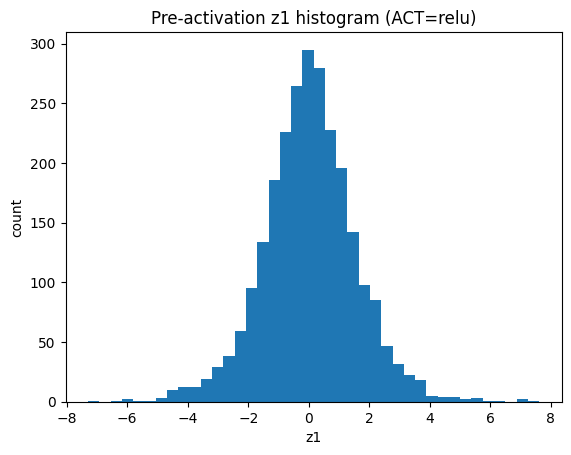

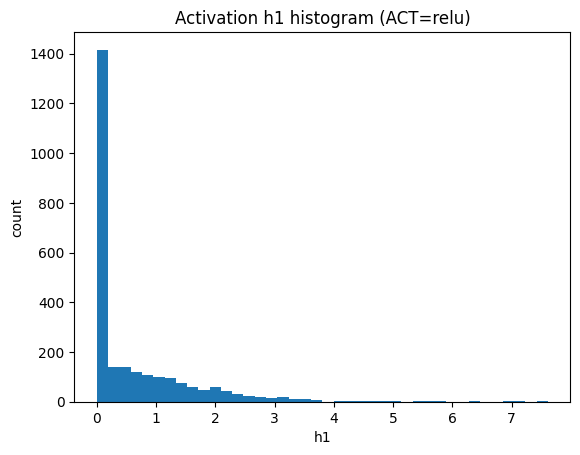

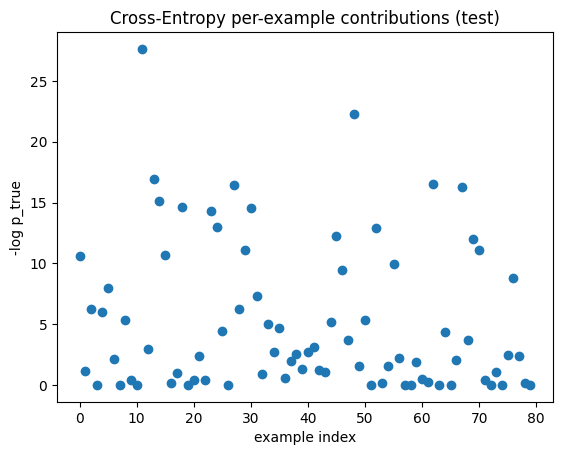

In [7]:

# Grab intermediates on TEST split for plots
z1_test, h1_test, z2_test = inter_test

# Histograms of z1 and h1
plt.figure()
plt.hist(z1_test.ravel(), bins=40)
plt.title(f"Pre-activation z1 histogram (ACT={ACT})")
plt.xlabel("z1"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(h1_test.ravel(), bins=40)
plt.title(f"Activation h1 histogram (ACT={ACT})")
plt.xlabel("h1"); plt.ylabel("count")
plt.show()

if MODE == "regression":
    yhat_test = yhat_test  # from above
    mse_contrib = (yhat_test - y_test)**2
    mae_contrib = np.abs(yhat_test - y_test)

    plt.figure()
    plt.scatter(y_test, mse_contrib, label="MSE contrib")
    plt.scatter(y_test, mae_contrib, label="MAE contrib")
    plt.title("Per-example contributions (test)")
    plt.xlabel("y_true"); plt.ylabel("loss contribution")
    plt.legend()
    plt.show()

else:
    # CE contributions = -log p_true
    idx = (np.arange(len(y_test)), y_test)
    ce_contrib = -np.log(np.clip(p_test[idx], 1e-12, 1-1e-12))

    plt.figure()
    plt.scatter(np.arange(len(ce_contrib)), ce_contrib)
    plt.title("Cross-Entropy per-example contributions (test)")
    plt.xlabel("example index"); plt.ylabel("-log p_true")
    plt.show()


### Analysis: Activation Saturation and Loss Contributions

**Instructions:**  
Examine the histograms and scatter plots you generated above.

- **For activation histograms:**  
  - Compare the shapes of `z1` (pre-activation) and `h1` (post-activation).  
  - Are most values centered around zero, or are they saturating near the limits of the activation function (e.g., 0/1 for Sigmoid, -1/1 for Tanh, or zeros for ReLU)?  
  - What might this imply about gradient flow and neuron activity?

- **For regression plots:**  
  - How do individual examples contribute differently to MSE vs. MAE?  
  - Do outliers dominate one loss more than the other?

- **For classification plots:**  
  - Observe the distribution of `−log p_true` values (per-example cross-entropy).  
  - Which examples have the largest contributions, and what does that suggest about model confidence or misclassifications?

**Your task:**  
Write a short discussion (5–10 sentences) summarizing your observations.  
Reflect on how **activation choice** and **weight scaling (`w_scale_1`)** affect saturation and model behavior.



## Part G — Multi-Activation Benchmark (TODO)

Loop over several activations and compare metrics in a single table.  
**Tip:** keep the **same fixed weights** `W1, b1, W2, b2` while changing only the activation.


In [8]:

ACT_LIST = ["relu", "tanh", "sigmoid", "gelu"]  # TODO: extend/trim

def eval_activation(act_name):
    if MODE == "regression":
        yhat = mlp_forward(X_test, act_name)
        return {"ACT": act_name, "MSE_test": mse(y_test, yhat), "MAE_test": mae(y_test, yhat)}
    else:
        p = mlp_forward(X_test, act_name)
        def acc(y_true, y_pred): return float(np.mean(y_true == y_pred))
        return {"ACT": act_name, "CE_test": ce_multiclass(y_test, p), "ACC_test": acc(y_test, np.argmax(p, axis=1))}

bench_rows = [eval_activation(a) for a in ACT_LIST]
df_bench = pd.DataFrame(bench_rows)
df_bench.sort_values(df_bench.columns[1], inplace=True)  # sort by the metric column
df_bench


,ACT,CE_test,ACC_test
2,sigmoid,2.334392,0.3000
1,tanh,3.732930,0.2875
3,gelu,5.132231,0.2875
0,relu,5.223618,0.3000


### Analysis: Comparing Activation Functions

**Instructions:**  
Review the table above that summarizes test performance for different activation functions (`ACT_LIST`).

- **For regression:**
  - Compare the **MSE** and **MAE** values across activations.
  - Which activation yields the lowest error?  
  - How might nonlinearities like `tanh` or `sigmoid` behave differently from `ReLU` or `GELU` in this dataset?

- **For classification:**
  - Examine the **Cross-Entropy (CE)** and **Accuracy (ACC)** metrics.
  - Which activation produces the best balance between loss and accuracy?  
  - Are there signs of under- or over-saturation for certain activations (e.g., sigmoid outputs too flat)?

**Your task:**  
Write a concise analysis (around 5–8 sentences) interpreting these results.  
Discuss how activation choice affects model expressiveness, stability, and performance — and whether the observed ranking aligns with your expectations.



## Part H — Weight-Scale Sweep (Evaluation-Only Experiment)

Increase/decrease `w_scale_1` (and/or input scale) to push activations into **saturation** or **linear** regimes.  
Observe how metrics change. Keep parameters **fixed per setting**; you are NOT training anything.


In [ ]:
# NOTE: We want to sweep w_scale_1 while avoiding unintended drift in globals.
#       We'll (re)sample fresh weights per scale from a fixed RNG seed stream.

# TODO: Define the list of scales to sweep for W1 (e.g., [0.2, 0.5, 0.8, 1.2, 2.0])
# scales = [...]

# TODO: Initialize a master RNG with a fixed seed (e.g., 999) so each run is reproducible
# rng_master = np.random.default_rng(999)

# TODO: Implement a helper that (re)initializes W1,b1,W2,b2 for a given scale1
#       and evaluates performance on the TEST split using the current ACT.
# def resample_and_eval(scale1):
#     # Low-value: declare globals (W1, b1, W2, b2) since we reassign them
#     # global W1, b1, W2, b2
#
#     # 1) Re-sample first-layer params with scale1:
#     #    - W1 ~ N(0,1) with shape (d, m), scaled by scale1
#     #    - b1 ~ N(0,1) with shape (m,), scaled by b_scale_1
#     #    Use rng_master for both so the sequence is deterministic across scales
#
#     # 2) Re-sample second-layer params with fixed scales (w_scale_2, b_scale_2):
#     #    - If MODE == "regression": W2 shape (m,1), b2 shape (1,)
#     #    - Else (classification):   W2 shape (m,C), b2 shape (C,)
#
#     # 3) Forward on TEST split with current ACT:
#     #    - If regression: yhat = mlp_forward(X_test, ACT)
#     #      * Compute MSE_test and MAE_test via mse/mae
#     #      * Return a dict: {"w_scale_1": scale1, "MSE_test": ..., "MAE_test": ...}
#     #    - Else: p = mlp_forward(X_test, ACT)
#     #      * Compute CE_test via ce_multiclass(y_test, p)
#     #      * Compute ACC_test via argmax + mean equality
#     #      * Return a dict: {"w_scale_1": scale1, "CE_test": ..., "ACC_test": ...}
#     # return {...}

# TODO: Build a DataFrame by mapping resample_and_eval over all scales:
#       - rows = [resample_and_eval(s) for s in scales]
#       - df_sweep = pd.DataFrame(rows)

# TODO: Display df_sweep as the final line to show results
# df_sweep


,w_scale_1,CE_test,ACC_test
0,0.2,1.308849,0.3500
1,0.5,3.001836,0.3750
2,0.8,4.181807,0.2375
3,1.2,5.134633,0.2875
4,2.0,6.592000,0.4375


In [ ]:
# ================== Unit Tests for w_scale_1 Sweep (print-only PASS/FAIL) ==================

import numpy as np
import pandas as pd

results = []

def run_test(fn):
    try:
        ok = bool(fn())
    except Exception:
        ok = False
    results.append("PASS" if ok else "FAIL")

tests = []

# 1) Required globals exist and are of expected types
tests.append(lambda: all(k in globals() for k in [
    'scales','rng_master','resample_and_eval','df_sweep','MODE'
]) and isinstance(scales, (list, tuple)) and callable(resample_and_eval) and isinstance(df_sweep, pd.DataFrame))

# 2) df_sweep has one row per scale
tests.append(lambda: len(df_sweep) == len(scales))

# 3) df_sweep contains a 'w_scale_1' column matching the provided scales (order preserved)
tests.append(lambda: 'w_scale_1' in df_sweep.columns and list(df_sweep['w_scale_1']) == list(scales))

# 4) Correct metric columns are present depending on MODE
tests.append(lambda:
    (MODE == "regression" and set(df_sweep.columns) == {"w_scale_1","MSE_test","MAE_test"}) or
    (MODE == "classification" and set(df_sweep.columns) == {"w_scale_1","CE_test","ACC_test"})
)

# 5) All metric values are finite
def _finite_metrics():
    if MODE == "regression":
        return np.isfinite(df_sweep["MSE_test"]).all() and np.isfinite(df_sweep["MAE_test"]).all()
    else:
        return np.isfinite(df_sweep["CE_test"]).all() and np.isfinite(df_sweep["ACC_test"]).all()
tests.append(_finite_metrics)

# 6) Metric ranges valid
def _metric_ranges():
    if MODE == "regression":
        return (df_sweep["MSE_test"] >= 0).all() and (df_sweep["MAE_test"] >= 0).all()
    else:
        ce_ok = (df_sweep["CE_test"] >= 0).all()
        acc_ok = ((df_sweep["ACC_test"] >= 0) & (df_sweep["ACC_test"] <= 1)).all()
        return ce_ok and acc_ok
tests.append(_metric_ranges)

# 7) resample_and_eval returns dict with expected keys for a valid scale
def _ree_keys_ok():
    s = scales[0]
    out = resample_and_eval(s)
    if MODE == "regression":
        return set(out.keys()) == {"w_scale_1","MSE_test","MAE_test"} and out["w_scale_1"] == s
    else:
        return set(out.keys()) == {"w_scale_1","CE_test","ACC_test"} and out["w_scale_1"] == s
tests.append(_ree_keys_ok)

# 8) Calling resample_and_eval on another scale returns finite metrics (does not crash)
def _ree_finite_ok():
    s = scales[-1]
    out = resample_and_eval(s)
    vals = [v for k,v in out.items() if k != "w_scale_1"]
    return all(np.isfinite(v) for v in vals)
tests.append(_ree_finite_ok)

# 9) df_sweep has unique scales (no duplicates)
tests.append(lambda: df_sweep["w_scale_1"].is_unique)

# 10) No NaNs present anywhere in df_sweep
tests.append(lambda: not df_sweep.isna().any().any())

# 11) rng_master exists and is a Generator (sanity)
tests.append(lambda: isinstance(rng_master, np.random.Generator))

# 12) resample_and_eval respects MODE by producing correctly shaped forward outputs
def _forward_shape_check():
    # Just verify mlp_forward still works with the current globals after resampling
    X_small = X_test[:min(5, len(X_test))]
    out = mlp_forward(X_small, ACT)
    if MODE == "regression":
        return isinstance(out, np.ndarray) and out.shape == (len(X_small),)
    else:
        return isinstance(out, np.ndarray) and out.shape[1] >= 2 and out.shape[0] == len(X_small) \
               and np.allclose(out.sum(axis=1), 1.0, atol=1e-5)
tests.append(_forward_shape_check)

# Run tests
for t in tests:
    run_test(t)

# Print only PASS/FAIL lines (in order)
for r in results:
    print(r)
# =========================================================================================


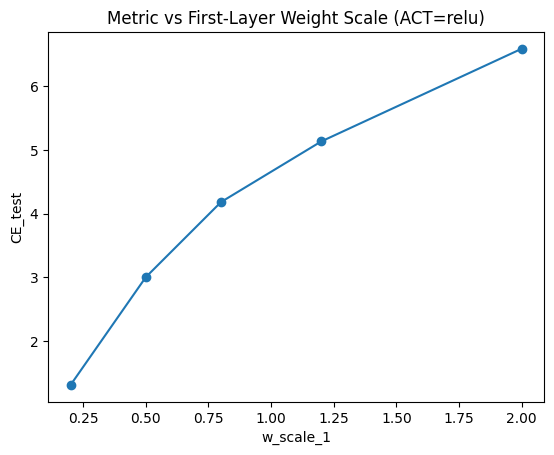

In [10]:

# Plot sweep results (pick the primary metric column automatically)
metric_cols = [c for c in df_sweep.columns if c.endswith("_test") and c != "ACC_test"]
primary = metric_cols[0] if metric_cols else "CE_test"

plt.figure()
plt.plot(df_sweep["w_scale_1"], df_sweep[primary], marker="o")
plt.title(f"Metric vs First-Layer Weight Scale (ACT={ACT})")
plt.xlabel("w_scale_1"); plt.ylabel(primary)
plt.show()


### Analysis: Effect of First-Layer Weight Scale

**Instructions:**  
Analyze the curve shown in the plot above.

- How does the model’s **test metric** (e.g., MSE, CE) change as `w_scale_1` increases?  
- Is there a clear **optimal scale** that minimizes error or loss?  
- What happens at very small vs. very large scales — do you observe signs of **underactivation** (too small weights) or **saturation/exploding activations** (too large weights)?  
- How does the activation function (`ACT`) influence this relationship?  

**Your task:**  
Write a short reflection (5–8 sentences) discussing how the first-layer weight scale affects model behavior and performance stability.  
Relate your explanation to the concepts of **activation saturation**, **gradient flow**, and **initialization sensitivity**.



## Part I — (Optional) Load Fixed Weights from `.npy` (TODO)

If you want reproducible fixed parameters from disk, load them here:
- `W1.npy` with shape `(d, m)`, `b1.npy` with shape `(m,)`
- `W2.npy` with shape `(m, out_dim)`, `b2.npy` with shape `(out_dim,)`

> After loading, **do not** modify weights during the notebook.


In [11]:

# Example hooks (commented):
# W1 = np.load("W1.npy"); b1 = np.load("b1.npy")
# W2 = np.load("W2.npy"); b2 = np.load("b2.npy")
# print(W1.shape, b1.shape, W2.shape, b2.shape)



## Summary & Reflection

- A **forward-only MLP** with fixed weights lets us isolate the effect of **activations** and **weight scales**.
- **Saturation** (Sigmoid/Tanh) or **dead ReLUs** can flatten outputs and worsen loss—even without training.
- The **weight-scale sweep** and **multi-activation benchmark** help you design informative *evaluation-only* experiments.

**Required write-up (2–3 paragraphs):**  
Summarize your findings with at least one figure (histogram or sweep plot) and one table (benchmark). Point out two cases where activation choice changes the ranking of models by the chosen metric.
